# part0: imports

In [2]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']

import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.mouse_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(defs)
    reload(dt)
    reload(params)
finally:
    os.chdir(nbPath)

# reading data

In [3]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = defs.prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

In [4]:
# load the DFs
allDFs_M1 = []
for df in AllDFs:
    if 'M1_rates' in df.columns:
        allDFs_M1.append(df)

allDFs_Str = []
for df in AllDFs:
    if 'Str_rates' in df.columns:
        allDFs_Str.append(df)

collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

## across mice, within area, across epochs, shuffled targets

so in short: different animals, different behaviours.

In [11]:
pairFileList1 = []
for I, df1 in enumerate(allDFs_M1):
    for J, df2 in enumerate(allDFs_M1):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList1.append((I,J))

pairFileList2 = []
for I, df1 in enumerate(allDFs_Str):
    for J, df2 in enumerate(allDFs_Str):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList2.append((I,J))


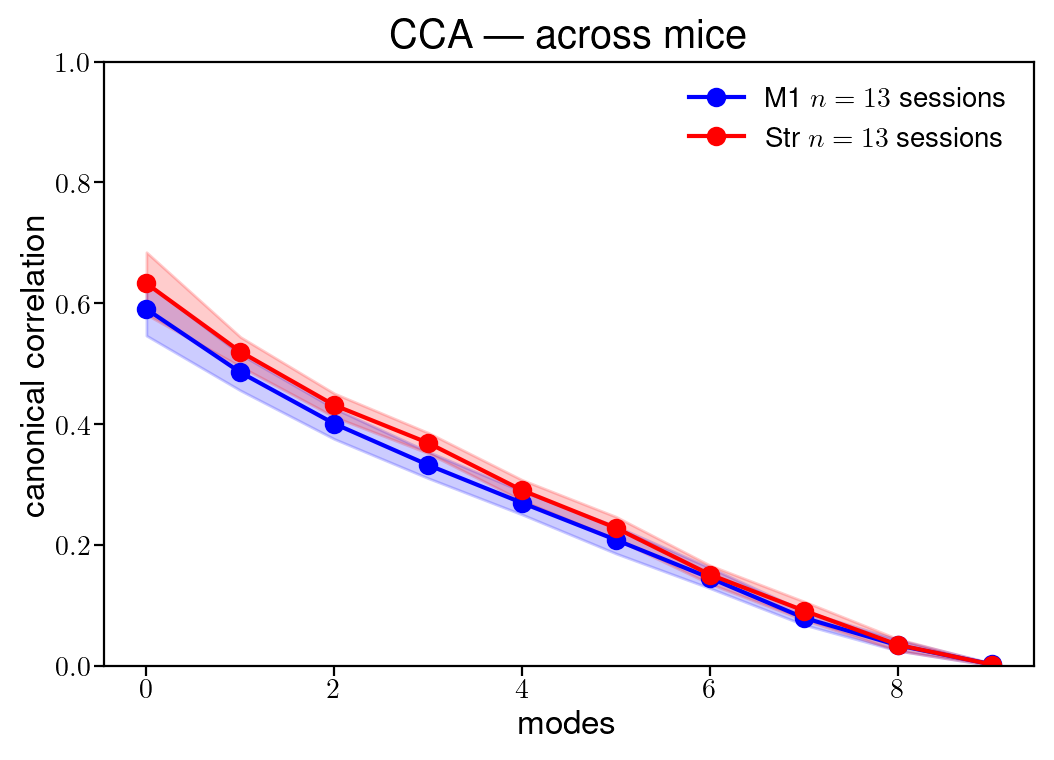

In [14]:
n_iter = params.n_iter * 10

side1df = [allDFs_M1[i] for i,_ in pairFileList1]
side2df = [allDFs_M1[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.prep_epoch, area=defs.areas[0], model=defs.n_components)
AllData2 = dt.get_data_array(side2df, defs.fixation_epoch, area=defs.areas[0], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)

side1df = [allDFs_Str[i] for i,_ in pairFileList2]
side2df = [allDFs_Str[j] for _,j in pairFileList2]
AllData1_ = dt.get_data_array(side1df, defs.prep_epoch, area=defs.areas[1], model=defs.n_components)
AllData2_ = dt.get_data_array(side2df, defs.fixation_epoch, area=defs.areas[1], model=defs.n_components)
_,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)
warnings.filterwarnings("default")

allCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    r = []
    for n in range(n_iter):
        sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
        sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

        data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        r.append(dt.canoncorr(data1, data2))
    allCCs0.append(r)
allCCs0 = np.array(allCCs0)
CC_lower_bound_M1 = np.percentile(allCCs0, 1, axis=1).T


allCCs1=[]
for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
    r = []
    for n in range(n_iter):
        sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
        sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

        data1 = np.reshape(sessionData1_sh[:,:min_trials_,:min_time_,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2_sh[:,:min_trials_,:min_time_,:], (-1,defs.n_components))
        r.append(dt.canoncorr(data1, data2))
    allCCs1.append(r)
allCCs1 = np.array(allCCs1)
CC_lower_bound_Str = np.percentile(allCCs1, 1, axis=1).T



if "__file__" in dir():  # runs when the notebook is being `imported` from another notebook
    print('variables: `CC_lower_bound_M1` and `CC_lower_bound_Str` hold the lower bound correlations')

if "__file__" not in dir():
    # plot
    _,ax = plt.subplots(dpi=100)
    utility.shaded_errorbar(ax, CC_lower_bound_M1, color='b', marker = 'o', label=f'{defs.areas[0]} $n={CC_lower_bound_M1.shape[1]}$ sessions')
    utility.shaded_errorbar(ax, CC_lower_bound_Str, color='r', marker = 'o', label=f'{defs.areas[1]} $n={CC_lower_bound_Str.shape[1]}$ sessions')
    ax.set_ylim([0,1])
    ax.set_xlabel('modes')
    ax.legend()
    ax.set_ylabel('canonical correlation')
    ax.set_title('CCA --- across mice', usetex=True);

    _,axes = plt.subplots(ncols=2, figsize=(10,5))
    axes[0].plot(CC_lower_bound_M1[:4,:].mean(axis=0),'.')
    axes[1].plot(CC_lower_bound_Str[:4,:].mean(axis=0),'.')
    axes[0].set_ylabel('average canonical correlation')
    for i, ax in enumerate(axes):
        ax.set_title(f'CCA --- across mice {defs.areas[i]} ');
        ax.set_ylim([0,1])
        ax.set_xlabel('sessions')
